# HL-HGAT Tutorial

#### This demo illustrates how to use the HL-HGAT model to perform sex classification on the ABCD dataset.

### load required packages

In [3]:
from torch.nn import Linear
import torch
import torch_geometric.nn as gnn
import torch.nn as nn
from torch.utils.data import Subset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import degree, to_undirected
from torch_geometric.data import Data
from lib.Hodge_Cheb_Conv import *
from lib.Hodge_Dataset import *
from lib.Spherical_mesh import *
import matplotlib.pyplot as plt

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## Introduction: Graphs in PyTorch Geometric


A graph is a data structure consisting of a collection of nodes (or vertices) connected by edges. The connections between nodes are represented by an adjacency matrix. In this matrix, if nodes are connected by an edge, the corresponding matrix element is set to one; if not, it is zero. For instance, if the 0-th and 1-st nodes are connected, the element in the first row and second column of the adjacency matrix will be one. The illustrated example depicts a graph with five nodes and seven edges. In the context of neuroscience, a brain functional network can be modeled as a binary undirected graph, where nodes represent distinct brain regions and edges indicate functional connectivity between these regions.

<div align='center'>
    <img src=fig/Graph_application.png width="1200">
</div>

Each graph in [`Torch Geometric`](https://pytorch-geometric.readthedocs.io/en/latest/index.html) is encapsulated within a [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) object. This object contains all necessary information to represent the graph effectively. The `graph` object comprises several key attributes tailored to applications in neuroscience:

1. **Graph Connectivity (`edge_index`)**: This attribute represents the adjacency matrix in a sparse matrix format. It stores the connectivity information as a tuple of source and destination node indices for each edge, offering a memory-efficient way to represent the network structure. This is particularly useful in modeling the complex interconnections between brain regions.

2. **Node Features (`x`)**: This refers to the attributes of each node, such as fMRI time-series data associated with each brain region, organized in a matrix with dimensions [number of nodes] x [number of features per node].

3. **Labels (`y`)**: Each graph can be labeled with clinically relevant information, such as the diagnostic category or demographic characteristics like the sex of each subject. This is crucial for tasks like graph-based classification in neuroscientific studies.

4. **Edge Features (`edge_attr`)**: Similar to node features, edge features may include measurements like functional connectivity strength between brain regions, formatted in a matrix with dimensions [number of edges] x [number of features per edge].

You can view a concise summary of these attributes and their dimensions by printing the `Data` object using `print(graph)`.

<div align='center'>
    <img src=fig/Graph_example.png width="800">
</div>

In [5]:
edge_index = torch.tensor([[0, 0, 0, 1, 1, 2, 3],
                           [1, 2, 3, 3, 4, 3, 4]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1],[0],[-1]], dtype=torch.float)
graph = Data(x=x, edge_index=edge_index, y=1, edge_attr=torch.rand(7,1))
print(graph)

Data(x=[5, 1], edge_index=[2, 7], edge_attr=[7, 1], y=1)


### Build HL-filters for node and edge features

In our approach, we use a boundary operator to describe how nodes and edges in a graph are connected, similar to an adjacency matrix. This helps us understand the relationships within the graph in a clear and structured way. 

<!-- $$
\partial_1 = \begin{bmatrix}
 -1 & -1 & -1 &  0 &  0 &  0 &  0 \\
  1 &  0 &  0 & -1 & -1 &  0 &  0 \\
  0 &  1 &  0 &  0 &  0 & -1 &  0 \\
  0 &  0 &  1 &  1 &  0 &  1 & -1 \\
  0 &  0 &  0 &  0 &  1 &  0 &  1 \\
\end{bmatrix}
$$ -->

<div align='center'>
    <img src=fig/boundary_operator.png width="800">
</div>

In [6]:
def adj2par1_HW(edge_index, num_node, num_edge):
    """
    Compute the 1-st boundary operator based on the undirected adjacency.
    
    Parameters
    ----------
    edge_index : undirected adjacency.
    num_node : number of nodes.
    num_edge : number of edges (undirected).

    Returns
    -------
    par1_sparse : boundary operator (sparse matrix).

    """
    
    par1_sparse = None
    
    ##############################################################################
    # TODO: Compute the boundary operator and save it in a sparse matrix format  #
    ##############################################################################

    return par1_sparse

par1 = adj2par1_HW(graph.edge_index, graph.num_nodes, graph.num_edges)
if par1 is not None:
    par1.to_dense()

We use Hodge-Laplacian operators to build HL node and edge filters. The $k$-th Hodge-Laplacian (HL) operator defined as 
$$
\boldsymbol{\mathcal{L}}_k = \boldsymbol{\partial}_{k+1} \boldsymbol{\partial}_{k+1}^{\top} + \boldsymbol{\partial}_k^{\top} \boldsymbol{\partial}_k.
$$
When $k=0$,  the $0$-th  HL operator is 
$$
\boldsymbol{\mathcal{L}}_0= \boldsymbol{\partial}_1 \boldsymbol{\partial}_1 ^\top
$$
over nodes.  When $k=1$,  the $1$-st HL operator is defined over edges as
$$
\boldsymbol{\mathcal{L}}_1 = \boldsymbol{\partial}_{2} \boldsymbol{\partial}_{2}^{\top} + \boldsymbol{\partial}_1^{\top} \boldsymbol{\partial}_1  \ .
$$

We define the convolution as 
$$
f'(\cdot)=\sum_{p=0}^{P-1}\theta_p T_p(\boldsymbol{\mathcal{L}}_k) f(\cdot).
$$

where $\theta_p$ is the $p ^{th}$ expansion coefficient associated with the $p ^{th}$ Laguerre polynomial $T_p$.  $T_p$ can be computed 
from the recurrence relation of $T_{p+1}(\lambda_k) = \frac{(2p+1-\lambda_k) T_{p}(\lambda_k)- pT_{p-1}(\lambda_k)}{p+1} $ with $T_0(\lambda_k) = 1$ and $T_1(\lambda_k) = 1 - \lambda_k$.

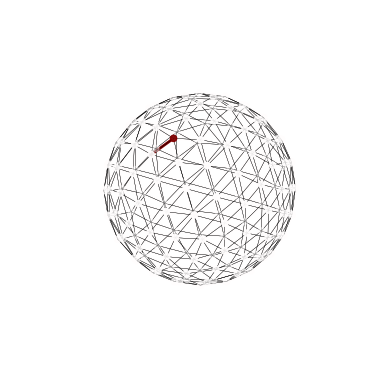

In [7]:
### build a spherical mesh
subdivisions = 2  # Adjust the number of subdivisions as needed
angle_x = 0 #np.pi / 8  # Rotate 45 degrees around x-axis
angle_y = 0 #np.pi / 4  # Rotate 45 degrees around y-axis
angle_z = 0 #np.pi / 4  # Rotate 45 degrees around z-axis
vertices, faces = create_icosphere(subdivisions, angle_x, angle_y, angle_z)
G = icosphere_to_graph(vertices, faces)

# Define pulse signal on one node and one edge
node_sig = torch.zeros(len(G.nodes),1).to(torch.float)
node_sig[4] = 1
edge_sig = torch.zeros(len(G.edges),1).to(torch.float)
edge_sig[24] = 1

plot_graph_3d(G, vertices, faces, node_colors=node_sig, edge_colors=edge_sig)

In [8]:
node_dic = {}
for i,e in enumerate(G.nodes):
    node_dic[e] = i
### compute boundary operator
inc = torch.zeros(len(G.nodes),len(G.edges),dtype=torch.long)
for i, e in enumerate(G.edges):
    inc[node_dic[e[0]]][i] = -1
    inc[node_dic[e[1]]][i] = 1

def Laguerre_polu(L,p=0):
    """
    Compute the p-th order Laguerre polynomial of the Laplacian matrix L.
    
    Parameters
    ----------
    L : Laplacian matrix.
    p : polynomial order.

    Returns
    -------
    Ln : p-th order Laguerre polynomial of the Laplacian matrix L.

    """
    Ln = None

    ##############################################################################
    # TODO: Compute the p-th order Laguerre polynomial of the Laplacian matrix L #
    ##############################################################################
    
    return Ln

def Simple_HL_filter(x, L, p, parameters=None):
    """
    Construct an Hodge-Laplacian filter.
    
    Parameters
    ----------
    x : input feature
    L : Laplacian matrix.
    p : polynomial order.
    parameters : specify the polynomial coefficent (None / list)
    Returns
    -------
    x : filtered feature.

    """
    
    if parameters is None:
        parameters = torch.rand(p+1)
    else:
        parameters = torch.tensor(parameters)
    ##############################################################################
    # TODO: Compute the p-th order Laguerre polynomial of the Laplacian matrix L #
    ##############################################################################

    return x


##############################################################################
# TODO: Compute the Hodge-Laplacian matrix L and filter signals with different
#       polynomial order#
##############################################################################


### viusalize the filtered node (x_n) and edge (x_e) signal with the following commarand
# plot_graph_3d(G, vertices, faces, node_colors=x_n, edge_colors=None)
# plot_graph_3d(G, vertices, faces, node_colors=None, edge_colors=x_e)

### Transform a graph to a heterogeneous graph

In practice, we implement graph convolution using torch-geometric, storing the 0-th Hodge-Laplacian operators as `edge_index_t` and `edge_weight_t`, and the 1-st Hodge-Laplacian operators as `edge_index_s` and `edge_weight_s` in a heterogeneous graph. To handle this efficiently, we utilize `PairData` from PyTorch Geometric instead of the standard `Data` object. `PairData` is tailored to manage the diverse elements of heterogeneous graphs effectively.

Within `PairData`, node features are represented as `x_t` and edge features as `x_s`. This setup allows us to treat nodes and edges as separate entity types, which is essential for the heterogeneous nature of the graph. We store only the upper triangle elements of the adjacency matrix in `edge_index` and convert it into the boundary operator $\partial_1 $ using the `adj2par1` function, which transforms it into a sparse matrix. This method ensures accurate representation and processing of the complex relationships between different graph components. The following is a function to transform a graph into a heterogeneous graph.

In [9]:
def graph2hgraph(data):
    '''
    transform a graph to a heterogeneous graph
    '''
    edge_index,edge_attr = to_undirected(data.edge_index, data.edge_attr, reduce='min')
    idx = edge_index[0]<edge_index[1]
    edge_index,edge_attr = edge_index[:,idx], edge_attr[idx]

    par1 = adj2par1(edge_index, data.x.shape[0], edge_index.shape[1]).to_dense()
    L0 = torch.matmul(par1, par1.T)
    lambda0, _ = torch.linalg.eigh(L0)
    maxeig = lambda0.max()
    L0 = 2*torch.matmul(par1, par1.T)/maxeig
    L1 = 2*torch.matmul(par1.T, par1)/maxeig
    x_s = edge_attr.view(-1,1)
    x_t = data.x
    data = PairData(x_s=x_s, edge_index_s=None, edge_weight_s=None,
                      x_t=x_t, edge_index_t=None, edge_weight_t=None,
                      y = data.y)
    edge_index_t, edge_weight_t = dense_to_sparse(L0)
    edge_index_s, edge_weight_s = dense_to_sparse(L1)
    data.edge_index_t, data.edge_weight_t = edge_index_t, edge_weight_t
    data.edge_index_s, data.edge_weight_s = edge_index_s, edge_weight_s
    data.num_node1 = data.x_t.shape[0]
    data.num_edge1 = data.x_s.shape[0]
    data.num_nodes = data.x_t.shape[0]
    data.edge_index=edge_index
    return data

###
# hgraph = graph2hgraph(graph)
# hgraph

### Build heterogeneous graph with brain fMRI

We store all brain fMRI data in a `.mat` file organized as a cell matrix with dimensions corresponding to the number of samples by four columns. Each row within this matrix represents a sample. The first column contains the fMRI time-series data, where each entry has dimensions equal to the number of ROIs multiplied by the number of time points. The second column, which is optional, holds the structural connectivity data with dimensions of number of ROIs by number of ROIs. If structural connectivity (SC) data is unavailable, this column can be left blank. The third column includes subject information, used for prediction or further analysis. The final column records the subject ID for each sample.


In [10]:
### Load '.mat' dataset
name = 'data/DEMO_DATA.mat'
matdata = loadmat(name)
matdata = matdata['DEMO_DATA']
num_samples = len(matdata)
num_rois = matdata[0][0].shape[0]
print('Number of samples: {} -- Number of ROIs: {}'.
      format(num_samples, num_rois))

Number of samples: 30 -- Number of ROIs: 268


In [11]:
### Compute group-level FC mask
k_ratio = 0.25   ## percentage of non-zero values in the mask
FC = torch.zeros(num_samples,num_rois,num_rois)
for i in range(num_samples):
    FC[i] = torch.corrcoef(torch.tensor(matdata[i][0]))
mask = FC2mask(FC, k_ratio=k_ratio)
masked_FC = mask * FC.mean(dim=0)
skeleton = masked_FC.to_sparse()
print('Number of functional connectivity after thresholding: {}'.
      format(len(skeleton.values())))

Number of functional connectivity after thresholding: 8844


In [12]:
par1 = adj2par1(skeleton.indices(), num_rois,
         skeleton.indices().shape[-1]).to_dense()
L0 = torch.matmul(par1, par1.T)
lambda0, _ = torch.linalg.eigh(L0)
maxeig = lambda0.max()
L0 = 2*torch.matmul(par1, par1.T)/maxeig
L1 = 2*torch.matmul(par1.T, par1)/maxeig
eit, ewt = dense_to_sparse(L0)
eis, ews = dense_to_sparse(L1)
graph = PairData(edge_weight_s=ews,edge_index_s=eis,
          x_s=skeleton.values().view(-1,1),x_t=torch.ones(num_rois,1),
          edge_index_t=eit,edge_weight_t=ewt,
          edge_index=skeleton.indices())
graph.num_node1 = num_rois
graph.num_edge1 = skeleton.indices().shape[1]
graph.num_nodes = num_rois
graph

PairData(edge_index_s=[2, 1416692], x_s=[8844, 1], edge_index_t=[2, 17956], x_t=[268, 1], edge_weight_s=[1416692], edge_weight_t=[17956], edge_index=[2, 8844], num_node1=268, num_edge1=8844, num_nodes=268)

## Simplex downsampling (graph coarsening)

We store node and edge cluster information in `pos_t` and `pos_s`, respectively. Nodes or edges within the same cluster are assigned the same index in these arrays. Any nodes or edges labeled as `inf` are discarded during the pooling process. Each coarsened heterogeneous graph is then appended to a list, resulting in each sample being represented by a list that contains graphs at various levels of spatial resolution.

<div align='center'>
    <img src=fig/pooling.png width="800">
</div>

In [13]:
### precompute pooling
graphs = [graph]
pool_num = 2  ### number of pooling layers
for i in range(pool_num):
    graph, c_node, c_edge = MLGC_Weight(graphs[i])
    graphs[i].pos_s, graphs[i].pos_t = c_edge, c_node
    graphs.append(graph)

num_nodepedges = []
for graph in graphs:
    par = adj2par1(graph.edge_index, graph.num_node1, graph.edge_index.shape[-1]).to_dense()
    num_nodepedges.append(par.shape[1] + par.shape[0]) ### number of nodes and edges after pooling
graphs

[PairData(edge_index_s=[2, 1416692], x_s=[8844, 1], edge_index_t=[2, 17956], x_t=[268, 1], edge_weight_s=[1416692], edge_weight_t=[17956], edge_index=[2, 8844], num_node1=268, num_edge1=8844, num_nodes=268, pos_s=[8844, 1], pos_t=[268, 1]),
 PairData(edge_index_s=[2, 231862], x_s=[2560, 1], edge_index_t=[2, 5262], x_t=[142, 1], edge_weight_s=[231862], edge_weight_t=[5262], edge_index=[2, 2560], num_node1=142, num_edge1=2560, num_nodes=142, pos_s=[2560, 1], pos_t=[142, 1]),
 PairData(edge_index_s=[2, 36241], x_s=[729, 1], edge_index_t=[2, 1537], x_t=[79, 1], edge_weight_s=[36241], edge_weight_t=[1537], edge_index=[2, 729], num_node1=79, num_edge1=729, num_nodes=79)]

## Dataset and graph batching

Neural networks are typically trained in batches. However, when dealing with graphs, the number of nodes or edges can differ between samples. PyTorch Geometric addresses this challenge by constructing a large composite graph for each batch. If we consider `n` samples, each with its own adjacency matrix $\{A_1, \dots, A_n\}$ and node features $\{X_1, \dots, X_n\}$, the adjacency matrix and node features for the batched graph are structured as follows:

$$
A = \begin{bmatrix}
A_1 & 0 & \cdots & 0 \\
0 & A_2 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & A_n
\end{bmatrix},
\quad
X = \begin{bmatrix}
X_1 \\
X_2 \\
\vdots \\
X_n
\end{bmatrix}.
$$

This arrangement ensures that each sample's graph structure is maintained within the batch, allowing for efficient processing of variable-sized graphs.


In [14]:
batch_size = 5
### mode: if 0, use functional connectivity as edge feature
###       if 1, use structural connectivity as edge feature
### y_idx: specifies the target element in the subject information to be predicted.
###        for example, in the DEMO data, the 9-th element corresponds to sex.
dataset = Brain_MLGC_ALL('Brain', matdata, skeleton.indices(), graphs, pool_num=pool_num,
                         mode=1, y_idx=8)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
graph_batch = next(iter(train_loader))
print(graph_batch[0])
# print(graph_batch[-1].ptr)

PairDataBatch(edge_index_s=[2, 7083460], x_s=[44220, 1], edge_index_t=[2, 89780], x_t=[1340, 375], edge_weight_s=[7083460], edge_weight_t=[89780], edge_index=[2, 44220], num_node1=[5], num_edge1=[5], num_nodes=1340, pos_s=[44220, 1], pos_t=[1340, 1], y=[5], batch=[1340], ptr=[6])


## Implement HL-HGAT

<div align='center'>
    <img src=fig/HGAT.png width="800">
</div>

### Temporal convolution of fMRI time-series
Hyperparameters of the inception module:
- in_channels: number of channels in the inception module
- maxpool: size of the sliding window
- if_readout: if reduce the time dimension with averaging

Inputs of the inception module:
- node signal (dimension: number of nodes $\times$ number of time points)

Outputs of the inception module:
- node signal (dimension: number of nodes $\times$ 4*num_channels)

In [15]:
node_dim = 32
time_pool_step = 5
timeconv = Inception1D(in_channels=node_dim,
                       maxpool=time_pool_step, if_readout=True)
print('size of the input node signal: {}'.format(graph_batch[0].x_t.shape))
x_t = timeconv(graph_batch[0].x_t)
print('size of the output node signal: {}'.format(x_t.shape))

size of the input node signal: torch.Size([1340, 375])
size of the output node signal: torch.Size([1340, 64])


### HL-filters
Convolutional layer on node and edge signals

Hyperparameters of the inception module:
- layers: number of HL-filtering layer
- channels: number of filters in each layer
- K: polynomial order
- node_dim: input node dimension
- edge_dim: input edge dimension

Inputs of the inception module:
- x_t, edge_index_t, edge_weight_t, x_s, edge_index_s, edge_weight_s

Outputs of the inception module:
- node and edge signal (dimension: number of nodes/edges $\times$ filters)


In [16]:
edge_dim = 1
dropout_ratio = 0.25
leaky_slope = 0.1
conv =  HL_filter(layers=1, channels=32, K=4, node_dim=node_dim*2,
                  edge_dim=edge_dim, dropout_ratio=dropout_ratio,
                  leaky_slope=leaky_slope,if_dense=False)
print('size of the input node and edge signal: {}, {}'.format(x_t.shape, graph_batch[0].x_s.shape))
x_t, x_s = conv(x_t, graph_batch[0].edge_index_t, graph_batch[0].edge_weight_t,
                graph_batch[0].x_s, graph_batch[0].edge_index_s, graph_batch[0].edge_weight_s)
print('size of the output node and edge signal: {}, {}'.format(x_t.shape, x_s.shape))

size of the input node and edge signal: torch.Size([1340, 64]), torch.Size([44220, 1])
size of the output node and edge signal: torch.Size([1340, 32]), torch.Size([44220, 32])


### Multi-simplicial Interaction (MSI)
MSI layer on node and edge signals

Hyperparameters of MSI:
- d: input feature dim
- dk: feature dim of key & query
- dv: feature dim of value
- dl: feature dim of latent
- only_att: if true, only output the attention value
- sigma: activation function

Inputs of MSI:
- x_t, x_s: node and edge signals
- par_1: boundary operator (sparse matrix, dim: [number of nodes, number of edges])
- D: degree matrix (dim: number of nodes)

Outputs of MSI:
- node and edge signal (dimension: number of nodes/edges $\times$ filters)


In [17]:
msi = MSI(d=32, dv=32)
par_1 = adj2par1(graph_batch[0].edge_index, x_t.shape[0], x_s.shape[0])
D = degree(graph_batch[0].edge_index.view(-1),num_nodes=x_t.shape[0]) + 1e-6
print('size of the input node and edge signal: {}, {}'.format(x_t.shape, x_s.shape))
x_t, x_s = msi(x_t, x_s, par_1, D)
print('size of the output node and edge signal: {}, {}'.format(x_t.shape, x_s.shape))

size of the input node and edge signal: torch.Size([1340, 32]), torch.Size([44220, 32])
size of the output node and edge signal: torch.Size([1340, 32]), torch.Size([44220, 32])


### Simplicial Attention Pooling (SAP)

<div align='center'>
    <img src=fig/pooling_architecture.png width="800">
</div>

Hyperparameters of SAP:
- d: input feature dim
- dk: feature dim of key & query

Inputs of MSI:
- x_t, x_s: node and edge signals
- par_1: boundary operator (sparse matrix, dim: [number of nodes, number of edges])
- D: degree matrix (dim: number of nodes)
- graph_batch: a list of graphs
- pos_ts, pos_ss: two lists of the node and edge cluster indices
- k: spatial level, increase 1 after pooling

Outputs of MSI:
- x_t, x_s: node and edge signals
- par_1: boundary operator (sparse matrix, dim: [number of nodes, number of edges])
- D: degree matrix (dim: number of nodes)
- k: spatial level
- edge_index_t ... : updated Hodge-Laplacian operator
- att_t, att_s: node and edge attention

In [18]:
fc = SAPool(d=32, dk=16)
pos_ts, pos_ss = [], []
for p in range(pool_num):
    n_batch = torch.cat( [torch.tensor([i]*nn) for i,nn in enumerate(graph_batch[p].num_node1)], dim=-1)
    s_batch = torch.cat( [torch.tensor([i]*nn) for i,nn in enumerate(graph_batch[p].num_edge1)], dim=-1)
    n_ahead = torch.cumsum(torch.cat([torch.zeros(1),graph_batch[p+1].num_node1],dim=-1), dim=0,
                           dtype=torch.long)[:-1]
    s_ahead = torch.cumsum(torch.cat([torch.zeros(1),graph_batch[p+1].num_edge1],dim=-1), dim=0,
                           dtype=torch.long)[:-1]
    pos_ts.append((graph_batch[p].pos_t.view(-1) + n_ahead[n_batch]).view(-1,1))
    pos_ss.append((graph_batch[p].pos_s.view(-1) + s_ahead[s_batch]).view(-1,1))

k = 0  ## spatial level, increase 1 after pooling
print('size of the input node and edge signal: {}, {}'.format(x_t.shape, x_s.shape))
x_t, x_s, par_1, D, k, edge_index_t, edge_weight_t, edge_index_s, edge_weight_s, att_t, att_s = fc(x_t, x_s, par_1, D, graph_batch, pos_ts, pos_ss, k, device='cpu')
print('size of the output node and edge signal: {}, {}'.format(x_t.shape, x_s.shape))

size of the input node and edge signal: torch.Size([1340, 32]), torch.Size([44220, 32])
size of the output node and edge signal: torch.Size([710, 32]), torch.Size([12800, 32])


### HL-HGAT

In [19]:
class HL_HGAT(torch.nn.Module):
    def __init__(self, num_layers=[2,2,2], channels=[32,64,128], mlp_channels=[],
                 K=4, node_dim=64, time_pool_step=5, edge_dim=1, keig=0, dk=64,
                 num_classes=1, dropout_ratio=0.0, pool_num=2, leaky_slope = 0.1,
                 num_nodepedge=None):
        super(HL_HGAT, self).__init__()
        self.num_layers = num_layers
        self.channels = channels
        self.mlp_channels = mlp_channels
        self.node_dim = node_dim + keig
        self.edge_dim = edge_dim + keig
        self.initial_channel = self.channels[0]
        self.pool_loc = [i for i in range(pool_num)]
        self.keig = keig # number of eigenvalue
        self.num_nodepedge = num_nodepedge

        ## Temporal convolution of fMRI time-series
        self.node_embedding = Inception1D(in_channels=node_dim, maxpool=time_pool_step,
                                          if_readout=True)
        ## Initial HL-filter
        self.HL_init_conv = HL_filter(layers=1, channels=self.initial_channel, K=K,
                                      node_dim=self.node_dim*2, edge_dim=self.edge_dim,
                                      dropout_ratio=dropout_ratio, leaky_slope=leaky_slope,
                                      if_dense=False)
        gcn_insize = self.initial_channel

        ## multiple blocks
        for i, gcn_outsize in enumerate(self.channels):
            if self.num_layers[i] == 0:
                continue
            fc = HL_filter(layers=self.num_layers[i], channels=gcn_outsize, K=K, node_dim=gcn_insize,
                           edge_dim=gcn_insize, dropout_ratio=dropout_ratio, leaky_slope=leaky_slope)
            setattr(self, 'HLconv{}'.format(i), fc)
            gcn_insize = gcn_insize + self.num_layers[i]*gcn_outsize

            fc = MSI(d=gcn_insize, dv = gcn_outsize)
            setattr(self, 'MSI{}'.format(i), fc)
            gcn_insize = gcn_insize + gcn_outsize

            if i in self.pool_loc:
                fc = SAPool(d=gcn_insize, dk=dk)
                setattr(self, 'SAP{}'.format(i), fc)

        ## Readout
        self.t_readout = Linear(gcn_outsize, 1)
        self.s_readout = Linear(gcn_outsize, 1)

        ## output layer
        mlp_insize = self.num_nodepedge
        for i, mlp_outsize in enumerate(mlp_channels):
            fc = nn.Sequential(
                Linear(mlp_insize, mlp_outsize),
                nn.BatchNorm1d(mlp_outsize),
                nn.LeakyReLU(negative_slope=leaky_slope),
                nn.Dropout(dropout_ratio),
                )
            setattr(self, 'mlp%d' % i, fc)
            mlp_insize = mlp_outsize

        self.out = Linear(mlp_insize, num_classes)

    def forward(self, datas, device='cuda:0'):
        data = datas[0].to(device)
        # 1. node & edge postion
        pos_ts, pos_ss = [], []
        for p in range(len(self.pool_loc)):
            n_batch = torch.cat( [torch.tensor([i]*nn) for i,nn in enumerate(datas[p].num_node1)], dim=-1)
            n_batch = n_batch.to(device)
            s_batch = torch.cat( [torch.tensor([i]*nn) for i,nn in enumerate(datas[p].num_edge1)], dim=-1)
            s_batch = s_batch.to(device)
            n_ahead = torch.cumsum(torch.cat([torch.zeros(1),datas[p+1].num_node1],dim=-1).to(device), dim=0, dtype=torch.long)[:-1]
            s_ahead = torch.cumsum(torch.cat([torch.zeros(1),datas[p+1].num_edge1],dim=-1).to(device), dim=0, dtype=torch.long)[:-1]
            pos_ts.append((datas[p].pos_t.to(device).view(-1) + n_ahead[n_batch]).view(-1,1))
            pos_ss.append((datas[p].pos_s.to(device).view(-1) + s_ahead[s_batch]).view(-1,1))

        x_s, edge_index_s, edge_weight_s = data.x_s, data.edge_index_s, data.edge_weight_s
        x_t, edge_index_t, edge_weight_t = data.x_t, data.edge_index_t, data.edge_weight_t

        # 2. Obtain node & edge embeddings
        x_t = self.node_embedding(x_t)

        x_t0, x_s0 = self.HL_init_conv(x_t, edge_index_t, edge_weight_t, x_s, edge_index_s, edge_weight_s)
        k = 0
        par_1 = adj2par1(datas[k].edge_index.to(device), x_t0.shape[0], x_s0.shape[0])
        D = degree(datas[k].edge_index.view(-1).to(device),num_nodes=x_t0.shape[0]) + 1e-6
        for i, channel in enumerate(self.num_layers):
            if channel == 0:
                continue
            fc = getattr(self, 'HLconv{}'.format(i))
            x_t0, x_s0 = fc(x_t0, edge_index_t, edge_weight_t, x_s0, edge_index_s, edge_weight_s,par_1,D)
            fc = getattr(self, 'MSI{}'.format(i))
            x_t, x_s = fc(x_t0, x_s0, par_1, D)
            x_t0 = torch.cat([x_t0, x_t], dim=-1)
            x_s0 = torch.cat([x_s0, x_s], dim=-1)

            # structural pooling
            if i in self.pool_loc:
                fc = getattr(self, 'SAP{}'.format(i))
                x_t0, x_s0, par_1, D, k, edge_index_t, edge_weight_t, edge_index_s, edge_weight_s, att_t, att_s = fc(x_t0, x_s0, par_1, D,
                                                                                                                     datas, pos_ts, pos_ss,
                                                                                                                     k, device=device)
                if k == 1:
                    node_att, edge_att = att_t.view(data.num_graphs,-1), att_s.view(data.num_graphs,-1)

        # 2. Readout layer
        x_t = self.t_readout(x_t)
        x_s = self.s_readout(x_s)
        x = torch.cat([x_s.view(data.num_graphs,-1), x_t.view(data.num_graphs,-1)], dim=-1)

        # 3. Apply a final classifier
        for i, _ in enumerate(self.mlp_channels):
            fc = getattr(self, 'mlp%d' % i)
            x = fc(x)

        return self.out(x), x, node_att, edge_att

### Building HL-HGAT with Three Blocks

HL-HGAT is designed to be highly modular, allowing users to construct a model with multiple blocks. Each block consists of several HL-filtering layers and a Multi-Simplicial Interaction (MSI) layer. The configuration of these blocks is controlled by the `num_layers` and `channels` lists, which determine the number of HL-filtering layers and the number of channels for each layer, respectively.

##### Hyperparameters of the HL-HGAT:
- **num_layers**: List detailing the number of HL-filtering layers in each block (e.g., if there are two blocks, the length of this list is 2).
- **num_channels**: List specifying the number of channels in each HL-filtering layer, with the same length as `num_layers`.
- **mlp_channels**: List indicating the number of neurons in each fully connected layer (empty if there are no hidden layers).
- **init_time_conv**: Specifies the number of channels in the initial temporal convolutional layer.
- **node_dim**: Defines the number of channels in the inception module.
- **time_pool_step**: Size of the sliding window used in pooling operations.

##### Inputs of the Inception Module:
- **graph_batch**: A list of batched graphs prepared for processing.

##### Outputs of the Inception Module:
- **pred**: The prediction results.
- **latent**: The latent representation from the final layer.
- **node_att**, **edge_att**: Node and edge attention metrics derived from the first layer.


In [20]:
pool_num = 2
#### An example of a HL-HGAT with three blocks and one fully connected layer
model = HL_HGAT(num_layers=[2,2,2], channels=[32,64,128], mlp_channels=[256],
                K=4, node_dim=64, time_pool_step=5, edge_dim=1,
                num_classes=1, dropout_ratio=0.0, pool_num=pool_num, leaky_slope = 0.1,
                keig=0, dk=64, num_nodepedge=num_nodepedges[pool_num]).to(device)
pred, latent, node_att, edge_att = model(graph_batch, device=device)
pred

tensor([[ 0.2551],
        [-0.1245],
        [-0.1498],
        [-0.7428],
        [-0.1011]], grad_fn=<AddmmBackward0>)

## Training and Testing

In [21]:
#### define training and testing sets
batch_size = 5
trainset = Subset(dataset, range(10))
testset = Subset(dataset, range(20,30))
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size)

#### define loss function
lr, l2 = 1e-4, 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
criterion = torch.nn.MSELoss()
criterion1 = torch.nn.L1Loss()

In [22]:
def train(loader):
    model.train()
    total_loss = 0
    y_pred, y = [], []
    for data in loader:  # Iterate in batches over the training dataset.
        out,_,_,_ = model(data, device=device)
        loss = criterion( out, data[0].y.view(-1,1))  # Compute the loss.
        total_loss += loss*data[0].num_graphs
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        y_pred.extend(out.squeeze())
        y.extend(data[0].y.squeeze())

    y_pred, y = torch.tensor(y_pred), torch.tensor(y)
    y_pred = (y_pred - y_pred.mean()) / y_pred.std()
    y = (y - y.mean()) / y.std()
    return torch.sqrt(total_loss/len(loader.dataset)), torch.mean(y_pred*y)


In [23]:
def test(loader):
    model.eval()
    y_pred, y = [], []
    total_loss, rmse = 0, 0

    for idx, data in enumerate(loader):  # Iterate in batches over the test dataset.
        with torch.no_grad():
            out,_,_,_ = model(data, device=device)
        loss = criterion1(out, data[0].y.view(-1,1))   # Compute the loss.
        rmse += criterion(out, data[0].y.view(-1,1))*data[0].num_graphs
        total_loss += loss * data[0].num_graphs
        y_pred.extend(out.squeeze())
        y.extend(data[0].y.squeeze())

    y_pred, y = torch.tensor(y_pred), torch.tensor(y)
    y_pred = (y_pred - y_pred.mean()) / y_pred.std()
    y = (y - y.mean()) / y.std()
    return torch.mean(y_pred*y), total_loss/len(loader.dataset), torch.sqrt(rmse/len(loader.dataset))


In [24]:
# num_epoch = 4  ### maximum number of epochs
# import time
# start = time.time()
# for epoch in range(0, num_epoch):
#     total_loss, train_corr = train(train_loader)
#     elapsed = (time.time()-start) / 60
#     print(f'Epoch: {epoch:03d}, time: {elapsed:.2f} Train Loss: {total_loss:.4f}, Train Corr: {train_corr:.4f}')

## Visualization

Given a pretrained model and part of testing data, we can visualize the results in a couple of ways.

In [25]:
### Load and preprocess testing data
edge_indices = torch.load('data/HGAT_graphs.pth')
skeleton = edge_indices[0]
num_rois = 268
par1 = adj2par1(edge_indices[0], num_rois, edge_indices[0].shape[-1]).to_dense()
L0 = torch.matmul(par1, par1.T)
lambda0, _ = torch.linalg.eigh(L0)
maxeig = lambda0.max()
L0 = 2*torch.matmul(par1, par1.T)/maxeig
L1 = 2*torch.matmul(par1.T, par1)/maxeig
eit, ewt = dense_to_sparse(L0)
eis, ews = dense_to_sparse(L1)
graph = PairData(x_s=torch.zeros(edge_indices[0].shape[1],1),edge_index_s=eis,
                x_t=torch.ones(num_rois,1),edge_index_t=eit,edge_weight_t=ewt,
                edge_weight_s=ews,edge_index=edge_indices[0])
graph.pos_s, graph.pos_t = edge_indices[2], edge_indices[3]
graph.num_node1 = num_rois
graph.num_edge1 = edge_indices[0].shape[1]
graph.num_nodes = num_rois
graphs = [graph]

num_rois = int(edge_indices[1].max()+1)
par1 = adj2par1(edge_indices[1], num_rois, edge_indices[1].shape[-1]).to_dense()
L0 = torch.matmul(par1, par1.T)
lambda0, _ = torch.linalg.eigh(L0)
maxeig = lambda0.max()
L0 = 2*torch.matmul(par1, par1.T)/maxeig
L1 = 2*torch.matmul(par1.T, par1)/maxeig
eit, ewt = dense_to_sparse(L0)
eis, ews = dense_to_sparse(L1)
graph = PairData(x_s=torch.zeros(edge_indices[1].shape[1],1),edge_index_s=eis,
                x_t=torch.ones(num_rois,1),edge_index_t=eit,edge_weight_t=ewt,
                edge_weight_s=ews,edge_index=edge_indices[1])
graph.pos_s, graph.pos_t = torch.zeros(edge_indices[1].shape[1],1), torch.ones(num_rois,1)
graph.num_node1 = num_rois
graph.num_edge1 = edge_indices[1].shape[1]
graph.num_nodes = num_rois
graphs.append(graph)
pool_num = 1
num_nodepedge = graphs[pool_num].num_edge1 + graphs[pool_num].num_node1
dataset = Brain_MLGC_ALL('Brain', matdata, skeleton, graphs, pool_num=pool_num)
dataloader = DataLoader(dataset, batch_size=5, shuffle=False)
graph_batch = next(iter(dataloader))

In [26]:
### Load pretrained model
pretrained_model = HL_HGAT(num_layers=[3,3], channels=[64,128], mlp_channels=[256],
                            K=4, node_dim=64, time_pool_step=5, edge_dim=1, num_classes=1,
                            dropout_ratio=0.0, pool_num=pool_num, leaky_slope = 0.1,
                            keig=0, dk=64, num_nodepedge=num_nodepedge).to(device)
pretrained_model.load_state_dict(torch.load('weights/HLHGAT_ABCD_FOLD0.pt',map_location=torch.device(device)))
# pred, latent, node_att, edge_att = pretrained_model(graph_batch, device=device)

<All keys matched successfully>

We can first visualize the latent representation of each subject with different embedding methods.

<div align='center'>
    <img src=fig/tsne_latent.png width="506">
    <img src=fig/pca_latent.png width="500">
</div>

In [27]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def visualize_latent_space(features, labels, method='tsne', perplexity=30, n_iter=1000, random_state=42, s=2):
    """
    Visualize the latent representation of the feature map.

    Parameters:
    - features (torch.Tensor): The feature map with shape [number of samples, number of features].
    - labels (torch.Tensor): The label matrix with shape [number of samples].
    - method (str): The dimensionality reduction method to use ('tsne' or 'pca').
    - perplexity (int): The perplexity parameter for t-SNE.
    - n_iter (int): The number of iterations for t-SNE.
    - random_state (int): The random seed for reproducibility.
    - s (int): size of each dot
    """

    ##############################################################################
    # TODO: visualize the latent space with PCA or tSNE.
    ##############################################################################


We can visualize the binary classification results with confusion matrices and roc curves.

<div align='center'>
    <img src=fig/confusion_matrix.png width="500">
    <img src=fig/roc_curve.png width="545">
</div>

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, normalize=False):
    """
    Plot the confusion matrix for binary classification.

    Parameters:
    - y_true (array-like): True labels.
    - y_pred (array-like): Predicted labels.
    - normalize (bool): Whether to normalize the confusion matrix.
    """
    ##############################################################################
    # TODO: visualize the confusion matrix.
    ##############################################################################

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(y_true, y_pred):
    """
    Plot the ROC curve for binary classification.

    Parameters:
    - y_true (array-like): True binary labels.
    - y_pred (array-like): Predicted probabilities.
    """
    ##############################################################################
    # TODO: visualize the ROC curve.
    ##############################################################################


## Citation
If you find this work useful, please cite our IPMI 2023 paper:
```bash
@inproceedings{huang2023heterogeneous,
  title={Heterogeneous Graph Convolutional Neural Network via Hodge-Laplacian for Brain Functional Data},
  author={Huang, Jinghan and Chung, Moo K and Qiu, Anqi},
  booktitle={International Conference on Information Processing in Medical Imaging},
  pages={278--290},
  year={2023},
  organization={Springer}
}
```
If you are using MSI and SAP modules, please cite our new submission:
```
@article{huang2024advancing,
  title={Advancing Graph Neural Networks with HL-HGAT: A Hodge-Laplacian and Attention Mechanism Approach for Heterogeneous Graph-Structured Data},
  author={Huang, Jinghan and Chen, Qiufeng and Bian, Yijun and Zhu, Pengli and Chen, Nanguang and Chung, Moo K and Qiu, Anqi},
  journal={arXiv preprint arXiv:2403.06687},
  year={2024}
}
```